# torch_net_dev

Developing the CNN in Keras/Theano.

In [1]:
# A bit of setup

# Usual imports
import time
import math
import numpy as np
import os
import matplotlib.pyplot as plt

import sys
sys.path.append('./util')

# Notebook plotting magic
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# For auto-reloading external modules
%load_ext autoreload
%autoreload 2

# My modules
import generate_data as d

def rel_error(x, y):
    """ Returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8. np.abs(x) + np.abs(y))))

In [2]:
import generate_data # My data function
import util.evaluation as ev

In [3]:
#Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
from torch.backends import cudnn

In [4]:
DATADIR = os.path.abspath('/home/franck/TRASH/SALAMI')
SALAMIDIR = os.path.abspath('/home/franck/TRASH/salami-data-public')
OUTPUTDIR = os.path.abspath('/home/franck/TRASH/cnn-music-structure/outputs')

ALL_SIDS = generate_data.get_sids(datadir=DATADIR)[0]
SIDS = []
for sid in ALL_SIDS:
    files = ev.id2filenames(
    sid,
    ann_type="uppercase",
        salamipath=SALAMIDIR,
    )
    if files:
        SIDS.append(sid)

In [5]:
# Get some small dataset
n_train = 1
n_val   = 1
n_test  = 1
n_total = n_train + n_val + n_test

n_sids = len(SIDS)
SID_SUBSET = np.random.choice(SIDS, size=n_total, replace=False)

train = generate_data.get_data(
    SID_SUBSET[:n_train],
    datadir=DATADIR,
    salamidir=SALAMIDIR,
    outputdir=OUTPUTDIR,
    prefix='train')
val   = generate_data.get_data(
    SID_SUBSET[n_train:n_train+n_val],
    datadir=DATADIR,
    salamidir=SALAMIDIR,
    outputdir=OUTPUTDIR,
    prefix='val'
    )
test  = generate_data.get_data(
    SID_SUBSET[n_train+n_val:],
    datadir=DATADIR,
    salamidir=SALAMIDIR,
    outputdir=OUTPUTDIR,
    prefix='test'
    )


Sid:  1195
SID: 1195,	file: 1195.mp3
Sid:  1349
SID: 1349,	file: 1349.mp3
Sid:  1043
SID: 1043,	file: 1043.mp3


In [6]:
# Show our data dictionary
print('Training data:')
for item in train:
    print ('\t', item, ':\t', train[item])

Training data:
	 1195 :	 {'X_path': '/home/franck/TRASH/cnn-music-structure/outputs/1195_X', 'y_path': '/home/franck/TRASH/cnn-music-structure/outputs/1195_y', 'X_shape': [11714, 1, 128, 129], 'y_shape': [11714, 1]}


In [7]:
# For now, just load in all the data
item_train = list(train.keys())[0]
item_val = list(val.keys())[0]

X_train = np.memmap(
    train[item_train]['X_path'],
    dtype='float32',
    mode='r',
    offset=0,
    shape=tuple(train[item_train]['X_shape'])
    )
y_train = np.memmap(
    train[item_train]['y_path'],
    dtype='float32',
    mode='r',
    offset=0,
    shape=tuple(train[item_train]['y_shape'])
    )

X_val = np.memmap(
    val[item_val]['X_path'],
    dtype='float32',
    mode='r',
    offset=0,
    shape=tuple(val[item_val]['X_shape'])
    )
y_val = np.memmap(
    val[item_val]['y_path'],
    dtype='float32',
    mode='r',
    offset=0,
    shape=tuple(val[item_val]['y_shape'])
    )

print ("Train: ", X_train.shape, y_train.shape)
print ("Val:   ", X_val.shape,   y_val.shape)

Train:  (11714, 1, 128, 129) (11714, 1)
Val:    (14462, 1, 128, 129) (14462, 1)


In [8]:
# Make it even smaller, for debugging
X_train = X_train[512:1024]
y_train = y_train[512:1024]

X_val = X_val[64:128]
y_val = y_val[64:128]

print("Train: ", X_train.shape, y_train.shape)
print("Val:   ", X_val.shape,   y_val.shape)

Train:  (512, 1, 128, 129) (512, 1)
Val:    (64, 1, 128, 129) (64, 1)


In [9]:
# Is it well behaved?
print("Inf values : ", np.any(np.isinf(X_train)))
print("Nan values : ", np.any(np.isnan(X_train)))

Inf values :  False
Nan values :  False


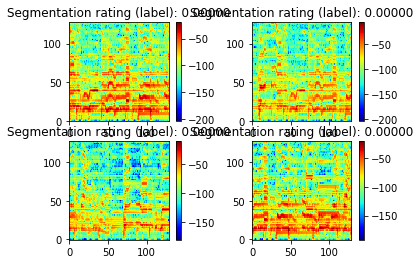

In [10]:
plt.rcParams['image.cmap'] = 'jet'
plt.figure()
for iPlot in range(1,5):
    plt.subplot(2,2,iPlot)
    samp = np.random.randint(0,X_train.shape[0])
    plt.imshow(X_train[samp,0], origin="lower")
    plt.colorbar()
    plt.title("Segmentation rating (label): {0:1.5f}".format(y_train[samp,0]))
plt.show()

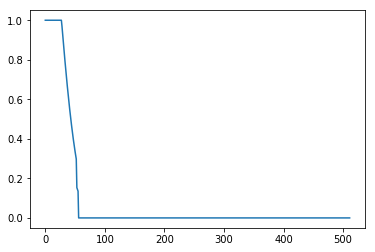

In [11]:
plt.plot(y_train)

## Torch dataloaders

In [12]:
class FrameDataset(data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, features, labels):
        'Initialization'
        self.labels = labels
        self.features = features

    def __len__(self):
        'Denotes the total number of samples'
        return self.features.shape[0]

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        X = self.features[index, :, :, :]
        X = torch.from_numpy(X)
        
        y = self.labels[index]
        y = torch.from_numpy(y)

        return X, y

In [13]:
# Parameters
params = {'batch_size': 64,
          'shuffle': True,
          'num_workers': 6}

In [14]:
# Generators
training_set = FrameDataset(X_train, y_train)
training_generator = data.DataLoader(training_set, **params)

validation_set = FrameDataset(X_val, y_val)
validation_generator = data.DataLoader(validation_set, **params)

## Torch network

In [15]:
class SegmentationNet(nn.Module):
    def __init__(self):
        super(SegmentationNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(16, 16, 3, padding=1)
        self.conv4 = nn.Conv2d(16, 16, 3, padding=1)
        #The paper actually has 128 neurons in the 1st fully connected layer
        self.fc1 = nn.Linear(16 * 32 * 32, 256)
        
        self.fc2 = nn.Linear(256, 1)
        self.dropout = nn.Dropout(p=0.25)
        self.batch_norm = nn.BatchNorm2d(16)
        
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

    def forward(self, x):
        #print(x.shape)
        x = self.batch_norm(F.relu(self.conv1(x)))
        #print(x.shape)
        x = self.batch_norm(F.relu(self.conv2(x)))
        #print(x.shape)
        x = self.dropout(self.pool(x))
        #print(x.shape)
        x = self.batch_norm(F.relu(self.conv3(x)))
        #print(x.shape)
        x = self.batch_norm(F.relu(self.conv2(x)))
        #print(x.shape)
        x = self.dropout(self.pool(x))
        #print(x.shape)
        x = x.view(-1, self.num_flat_features(x))
        x = self.fc1(x)
        x = self.fc2(x)
        return x


net = SegmentationNet()

## Train

In [16]:
# Loss and Optimizer
lr=1e-4
weight_decay=1e-6
momentum=0.9
nesterov=True

optimizer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum, nesterov=nesterov)  
#mean squarred logarithmic error
def msle(output, target):
    loss = torch.mean((torch.log(output + 1) - torch.log(target+1))**2)
    return loss

In [19]:
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
cudnn.benchmark = True

max_epochs = 10

net.to(device)

# Loop over epochs
for epoch in range(max_epochs):
    # Training
    running_loss = 0.0
    for i, data in enumerate(training_generator, 0):
        local_batch, local_labels = data
        
        # Transfer to GPU
        local_batch, local_labels = local_batch.to(device), local_labels.to(device)

        # Model computations
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(local_batch)
        loss = msle(outputs, local_labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

    # Validation
    with torch.set_grad_enabled(False):
        val_loss = 0.0 
        for cpt, data in enumerate(validation_generator, 0):
            local_batch, local_labels = data
            
            # Transfer to GPU
            local_batch, local_labels = local_batch.to(device), local_labels.to(device)

            # Model computations
            # forward + backward + optimize
            outputs = net(local_batch)
            loss = msle(outputs, local_labels)
            val_loss += loss.item()
        
        #cpt here is the last cpt in the loop, len(validator_generator) -1
        print(f'Epoch {epoch + 1} validation loss: {running_loss / (cpt+1)}')
            

Epoch 1 validation loss: 0.41406580060720444
Epoch 2 validation loss: 0.45568760484457016
Epoch 3 validation loss: 0.4175429604947567
Epoch 4 validation loss: 0.386197991669178
Epoch 5 validation loss: 0.41430553421378136
Epoch 6 validation loss: 0.37225066497921944
Epoch 7 validation loss: 0.40237826481461525
Epoch 8 validation loss: 0.3463642783463001
Epoch 9 validation loss: 0.3863343559205532
Epoch 10 validation loss: 0.39460449665784836


## ##

In [20]:
# Test!
item_test = list(test.keys())[0]
X_test = np.memmap(
    test[item_test]['X_path'],
    dtype='float32',
    mode='r',
    offset=0,
    shape=tuple(test[item_test]['X_shape'])
    )
y_test = np.memmap(
    test[item_test]['y_path'],
    dtype='float32',
    mode='r',
    offset=0,
    shape=tuple(test[item_test]['y_shape'])
    )

In [27]:
sid = test['sids'][0]

In [41]:
TRAIN_CAP = None
import threading

class DataGenerator(object):
    '''
    Generate minibatches from serialized data.
    '''
    def __init__(self, datadict, batch_size=32, shuffle=False, seed=None):
        self.lock = threading.Lock()
        self.data       = datadict
        self.batch_size = batch_size
        self.shuffle    = shuffle
        self.seed       = seed
        self = self.flow(
            datadict,
            batch_size=batch_size,
            shuffle=False,
            seed=None,
            save_to_dir=None,
            save_prefix="",
            save_format="jpeg")


    def next(self):
        # for python 2.x
        # Keep under lock only the mechainsem which advance the indexing of each batch
        # see # http://anandology.com/blog/using-iterators-and-generators/
        with self.lock:
            index_array, current_index, current_batch_size = next(self.flow_generator)
        # The transformation of images is not under thread lock so it can be done in parallel
        offsetmul = self.data['Xshape'][1] * self.data['Xshape'][2] * self.data['Xshape'][3]
        x_path = os.path.abspath(
            os.path.join(self.data['datadir'], self.data['Xfile'])
            )
        y_path = os.path.abspath(
            os.path.join(self.data['datadir'], self.data['yfile'])
            )
        bX = np.memmap(
            x_path,
            dtype='float32',
            mode='r',
            shape=(current_batch_size, self.data['Xshape'][1], self.data['Xshape'][2], self.data['Xshape'][3]),
            offset=current_index*offsetmul
            )
        bY = np.memmap(
            y_path,
            dtype='float32',
            mode='r',
            shape=(current_batch_size, 1),
            offset=current_index
            )
        return bX, bY

    def flow(self, datadict, batch_size=32, shuffle=False, seed=None,
             save_to_dir=None, save_prefix="", save_format="jpeg"):
        assert datadict['Xshape'][0] == datadict['yshape'][0]
        self.save_to_dir = save_to_dir
        self.save_prefix = save_prefix
        self.save_format = save_format
        self.flow_generator = self._flow_index(datadict['Xshape'][0], batch_size, shuffle, seed)
        return self

    def _flow_index(self, N, batch_size=32, shuffle=False, seed=None):

        # Check cap
        if TRAIN_CAP:
            N = min(N, TRAIN_CAP)

        b = 0
        total_b = 0
        while 1:
            if b == 0:
                if seed is not None:
                    np.random.seed(seed + total_b)

                if shuffle:
                    index_array = np.random.permutation(N)
                else:
                    index_array = np.arange(N)

            current_index = (b * batch_size) % N
            if N >= current_index + batch_size:
                current_batch_size = batch_size
            else:
                current_batch_size = N - current_index

            if current_batch_size == batch_size:
                b += 1
            else:
                b = 0
            total_b += 1
            yield index_array[current_index: current_index + current_batch_size], current_index, current_batch_size



NameError: name 'outputdir' is not defined

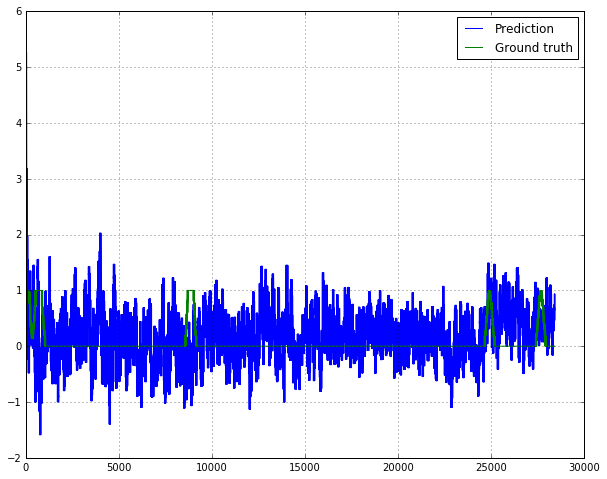

In [55]:
batch_size = 32

# TEST MODEL ###############################################################
test_batch_gen = DataGenerator(
    test,
    batch_size=batch_size,
    shuffle=False,
    seed=None
    )

n_batches = int(math.ceil(test['yshape'][0]/float(batch_size)))
y_pred = np.zeros((n_batches*batch_size, 1))
y_true = np.zeros((n_batches*batch_size, 1))
i_start = 0
for iBatch in xrange(n_batches):
    bX, by = test_batch_gen.next()
    n_batch = bX.shape[0]
    y_pred[i_start:i_start+n_batch] = np.array(model.predict_on_batch(bX))
    y_true[i_start:i_start+n_batch] = by[:]
    i_start += n_batch

plt.figure(3)
plt.plot(y_pred, label="Prediction")
plt.plot(y_true, label="Ground truth")
plt.grid()
plt.legend()
plt.savefig(
    os.path.abspath(os.path.join(outputdir, 'test.pdf')),
    bbox_inches='tight'
    )

plt.show()